# Collaborative Filtering


Collaborative Filtering is founded on the idea that individuals with similar tastes help others to know what they may/may not like without explicitly collecting data on them.

How can we decide which type of simlarity (user-user or item-item) should a recommender user?

**User-Item Matrices**

Dense vs. Sparse representations:
- Sparse representations show data in a non-trivial observation
- Dense shows data for both trivial and non-trivial observations

**User-User**
- Two users with similar tasetes will continue to have similar tastes
- To provide a recommendation for user A, find a similar user B and select from user B's list of likes that A hasn't seen yet
- Vector row similarity

**Item-Item**
- Two items with similar users will continue to be popular with users who are similar to them 
- To provide a recommendation for user A, find an item similar to a liked item they haven't seen yet
- Vector column similarity

**Soft Ratings**

How can we handle cases where a user has seen an item but provided no feedback? (think streaming servies where a user watches but provides no feedback)

Implicit data: 
- Exclude the item 
- User data as a separate term in the learner 
- Assign a default rating representing "interesting enough, but not significant enough to rate"

Implicit ratings are important when distriguishing between click vs. buy likelihood 

**Data Collection and User Logging**

What to log: 
- Ratings 
- Page loads, page views, clicks, items added/favorited

Propensity Scores and Matching
- Represents the probability that an observational unit is assigned to the treatment vs. control group
    - Helps assess the probability of recieving treatment given confounders 
    - Typically a logistic regression 
- Match most similar control records to treatment records using propensity scores to help balance the distributions

Important of Propensity Scores
- Considering the population of all items a user has seen is tied to score matching

Funnels 
- Collections of steps users take to transition from one state to antoher
- Drop off rates offer important characteristics of your system and recommendations
- Examining funnel performance offers an excellent starting point for improving/building recommendation systems
    - Drop offs dell us what might be confusing

Importance of Business Insights 
- What leads items to become more popular over time and how can we learn from those signals better?

## Mathematical Considerations

**Zipf's Law**

Zipf's Law states that given a large corpus of observations, the frequency of an observation is inversly proportional to its rank in the frequency table. As a result, Zipf's Law can have a huge impact on a recommendor system when not properly addressed.

The Matthew Effect (popularity bias)
- States the most popular items will continue to attract attention and widen this gap along the way
- More specifically that the probability of two users sharing an item in their rating drops with the square of its probability rank as demonsta
- These effects can be addressed by leveraging diversity-aware loss functions or down-stream sampling methods

Sparsity
- As ratings are skewed towards popular items, less popular items are data starved and the dataset exhibits sparsity
- Adds emphasis to the most popular users

**Similarity Calculations**

Pearson Correlation 
- Similarity of the jointly distributed variables describing the users' ratings 
- Compute via all co-rated items ... user similarity is defined via item ratings 
- This is a pairwise similarity measure

User-Item Affinity Scores
- Calculation taking a user's rating of item *x* accounting for a user's average adjusted rating of similarly-weighted average ratings of all the user's neighbors
- A user's rating will likely be the the average of people who hav ratings like thier ratings adjusted for their individual rating generousity 

**Explore-Exploit Recommendation Systems (Mutli-Armed Bandits)**

Take not only the outcome-maximizing recommendation but also a collection of variants then randomly determine which to use as a response
- Hold an assumption about what the greatest expected reward might be 
- Explore alternatives at some frequency
- Continue to update the distributions and estimations

e-greedy
- An algorithm for determining when to explore or use the reward optimizing arm
- *e*-greedy algorithms modify the systems server by using *e* to determing  if the recommendation comes from the ranker or random selection
- Starting with a large *e* and refining as time goes on is a steadfast approach

**NLP x Recommendation System Relationship**

*word2vec* assigns words meaning using co-occurence relationships
- Helps reduce the size of representations to the bottleneck dimension and gives us a smaller dimension space to compare 

Recommendation systems can apply this technique by using ordered sequences of user-item interactions
- User item similarity in place of word simlarity where user history represents a sentence
- Find item-item s

## Example 

Dataset: https://www.kaggle.com/datasets/dev0914sharma/dataset

### Exploratory Data Analysis

In [2]:
import pandas as pd 

# read in sample data from 
df = pd.read_csv("/Users/srmarshall/Desktop/data-dump/kaggle/movie_recommendations.csv")

In [3]:
# get a sense of what the data looks like
display(df.head())
display(df.tail())

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


,user_id,item_id,rating,timestamp
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156
100002,12,203,3,879959583


In [4]:
# what are the data types? how many observations?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
print(f'Unique users: {df["user_id"].nunique()}')
print(f'Unique items: {df["item_id"].nunique()}')
print(f'Possible ratings: {sorted(df["rating"].unique())}')

Unique users: 944
Unique items: 1682
Possible ratings: [1, 2, 3, 4, 5]


In [6]:
# aggregate by item
agg_ratings = df.groupby("item_id").agg(mean_rating =("rating", "mean"), 
                                        number_of_ratings = ("rating", "count"), 
                                        most_recent_timestamp = ("timestamp", "max")).reset_index()

In [7]:
agg_ratings.describe()

,item_id,mean_rating,number_of_ratings,most_recent_timestamp
count,1682.000000,1682.000000,1682.000000,1.682000e+03
mean,841.500000,3.076037,59.454816,8.914714e+08
std,485.695893,0.781654,80.390832,3.089867e+06
min,1.000000,1.000000,1.000000,8.747914e+08
25%,421.250000,2.659600,6.000000,8.915000e+08
50%,841.500000,3.161528,27.000000,8.927384e+08
75%,1261.750000,3.653428,80.000000,8.931946e+08
max,1682.000000,5.000000,584.000000,8.932866e+08


How might dropping items with low aggregate numbers of ratings impact my recommendation system: 

**Pros**
- Similarity calcualtions will be more reliable as items will have more feedback
- Computation load will be lower 
- Popular items amongs the group will be surfaced

**Cons**
- Reduced discoverability
    - Niche items may be incorrectly overlooked
    - System might end up with homogenous recommendations
    - New items may be diproportionally punished
- Popularity bias

corr:                        most_recent_timestamp  number_of_ratings
most_recent_timestamp               1.000000           0.355494
number_of_ratings                   0.355494           1.000000


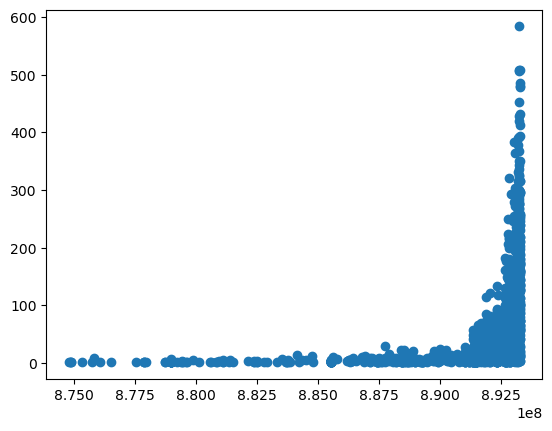

In [8]:
import matplotlib.pyplot as plt 

# print correlations 
print(f'corr: {agg_ratings[["most_recent_timestamp", "number_of_ratings"]].corr(method="pearson")}')

# scatter plot 
plt.scatter(agg_ratings["most_recent_timestamp"], agg_ratings["number_of_ratings"])
plt.show()

In [9]:
# drop items with less than 10 ratings 
agg_ratings_GT10 = agg_ratings[agg_ratings["number_of_ratings"] > 10]

In [10]:
agg_ratings_GT10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1119 entries, 0 to 1517
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   item_id                1119 non-null   int64  
 1   mean_rating            1119 non-null   float64
 2   number_of_ratings      1119 non-null   int64  
 3   most_recent_timestamp  1119 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 43.7 KB


What type of relationship exists between average rating and number of ratings for a given item?

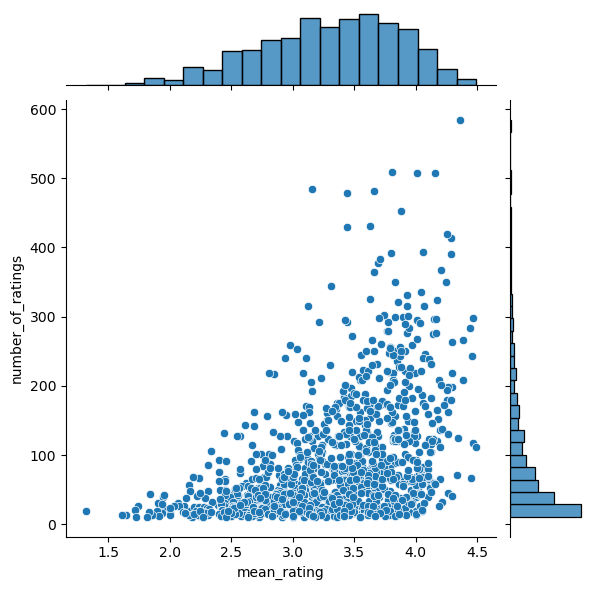

In [11]:
import seaborn as sns 

sns.jointplot(x="mean_rating", y="number_of_ratings", data=agg_ratings_GT10)

In [12]:
# apply less than 10 ratings filter to original dataset 
df_GT10 = pd.merge(df, agg_ratings_GT10[["item_id"]], 
                   on="item_id", 
                   how="inner")

In [13]:
print(f"Observations dropped: {len(df) - len(df_GT10)}")

Observations dropped: 2377


In [14]:
print(f'Unique users: {df_GT10["user_id"].nunique()}')
print(f'Unique items: {df_GT10["item_id"].nunique()}')
print(f'Possible ratings: {sorted(df_GT10["rating"].unique())}')

Unique users: 944
Unique items: 1119
Possible ratings: [1, 2, 3, 4, 5]


### Creating a User-Item Matrix 

Recall in a user-item matrix, the rows are users and the columns are items 

In [57]:
# create matrix using pivot table
ui_matrix = df_GT10.pivot_table(index="user_id", columns="item_id", values="rating")

In [58]:
ui_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1421,1428,1444,1446,1451,1469,1478,1480,1483,1518
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate similarities

Cosine
- Finds the similarity between two *samples* either from the same distribution or different distributions
- Samples must have the same number of features
- Ranges from -1 to 1 with 1 being most similar aren -1 being least similar

Pearson 
- Correlation between two *jointly distributed random variables*
- Ranges from -1 to 1 with 1 meaning the cariables are positively correlated and 1 meaning the variables are negatively correlated

Opt for Pearson correlation to leverage mean-centering operation to help offset any users that provide net high or low reviews

In [17]:
corr_matrix = ui_matrix.T.corr(method="pearson")

In [18]:
corr_matrix

user_id,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,-0.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.000000,1.608412e-01,0.112780,0.500000,0.419504,0.287159,0.258137,0.692086,-0.102062,...,0.061695,-2.602417e-01,0.383733,2.899974e-02,0.326744,5.343904e-01,0.263289,0.205616,-0.180784,0.067549
2,NaN,0.160841,1.000000e+00,0.067420,0.148522,0.327327,0.446269,0.643675,0.585491,0.242536,...,0.021007,-2.711631e-01,0.214017,5.616449e-01,0.331587,-6.694897e-18,-0.011682,-0.062017,0.085960,0.479702
3,NaN,0.112780,6.741999e-02,1.000000,-0.262600,NaN,-0.109109,0.064803,0.291937,NaN,...,NaN,NaN,-0.045162,-5.233642e-17,-0.137523,NaN,-0.104678,1.000000,-0.011792,NaN
4,NaN,0.500000,1.485221e-01,-0.262600,1.000000,1.000000,-0.581318,-0.266632,0.642938,NaN,...,0.500000,NaN,-0.203653,NaN,0.375000,NaN,0.850992,1.000000,0.412568,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,0.534390,-6.694897e-18,NaN,NaN,0.880705,0.206315,0.142404,-0.333333,NaN,...,0.374351,-3.305898e-02,0.471172,-2.758386e-01,-0.073374,1.000000e+00,-0.534522,-0.131306,-0.500000,-0.187317
940,NaN,0.263289,-1.168173e-02,-0.104678,0.850992,0.027038,-0.024419,0.000931,0.320487,0.171499,...,-0.125059,4.352858e-01,-0.338327,-1.486075e-01,0.110022,-5.345225e-01,1.000000,0.632746,-0.022813,0.332497
941,NaN,0.205616,-6.201737e-02,1.000000,1.000000,0.468521,0.399186,0.000000,0.166667,1.000000,...,-0.500000,-2.355139e-16,0.273060,3.929526e-01,-0.214147,-1.313064e-01,0.632746,1.000000,-0.577350,-0.395285


### Recommend Items

For a sample user:
- Find similar users 
- Identify items similar users liked and the original user has not seen 
- Surface those items to the original user as a recommendation

In [21]:
# set a sample user id
sample_user_id = 1

# filter matrix accordingly and sort
filtered_scores = corr_matrix[sample_user_id]
filtered_scores = filtered_scores.sort_values(ascending=False).drop(sample_user_id)

In [22]:
# display users with highest similarity scroes
filtered_scores.head(10)

user_id
810    1.0
273    1.0
531    1.0
39     1.0
811    1.0
812    1.0
351    1.0
166    1.0
511    1.0
866    1.0
Name: 1, dtype: float64

In [28]:
# convert to df 
filtered_scores_df = pd.DataFrame({
    "user_id": filtered_scores.index, 
    "corr": filtered_scores.values
})

In [29]:
filtered_scores_df

,user_id,corr
0,810,1.0
1,273,1.0
2,531,1.0
3,39,1.0
4,811,1.0
...,...,...
938,729,NaN
939,799,NaN
940,849,NaN
941,858,NaN


Use these similar users to surface new content for the sample user 

Conditions:
- Sample user must not have seen the piece of content (anti-join)

In [32]:
# extract a similar user 
similar_user_id = filtered_scores_df.iloc[0]["user_id"]

In [43]:
ui_matrix
# display(ui_matrix[similar_user_id])

item_id,1,2,3,4,5,6,7,8,9,10,...,1421,1428,1444,1446,1451,1469,1478,1480,1483,1518
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# create dataframe to help with recs
rec_df = pd.DataFrame({
    "item_id": ui_matrix.loc[sample_user_id].index,
    "sample_user": ui_matrix.loc[sample_user_id].values, 
    "similar_user": ui_matrix.loc[similar_user_id].values
})

In [70]:
# find items that similar user has seen but sample user has not 
rec_candididates = rec_df[~rec_df["similar_user"].isna() & rec_df["sample_user"].isna()]

In [75]:
# sort
sorted_rec_candididates = rec_candididates.sort_values(by="similar_user", ascending=False)

In [79]:
sorted_rec_candididates

,item_id,sample_user,similar_user
830,902,NaN,5.0
328,342,NaN,5.0
277,289,NaN,5.0
282,294,NaN,5.0
287,300,NaN,5.0
288,301,NaN,5.0
300,313,NaN,5.0
307,321,NaN,5.0
811,879,NaN,5.0
312,326,NaN,5.0


In [83]:
# set number of recommendations
n_recs = 5

# filter
rec_items_ids = sorted_rec_candididates["item_id"][:n_recs].values

In [86]:
# surface recs 
print(f"Recommendations for user {sample_user_id}")
for id in rec_items_ids:
    print(f"- {id}")

Recommendations for user 1
- 902
- 342
- 289
- 294
- 300
